In [1]:
import os
import sys
import itertools
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import Bio.PDB.Polypeptide as pp
from collections import Counter
sys.path.append('/Users/macbook/Documents/GitHub/perturbation-networks-get-data')
from getmutations import MutationsDict, GetMutations
%matplotlib inline

In [2]:
AA = list(pp.aa1)

In [3]:
path = "/Users/macbook/Documents/perturbation-networks/dms_data"
protein_path = "/Users/macbook/Documents/perturbation-networks/proteins"

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
def PlotHeatmap(dataframe, save_as=None, vmin=None, vmax=None):
    """Plot heatmap of dataframe values.
    
    Parameters:
        dataframe: data to plot
        save_as: name of file to save. If None, image is not saved
        vmin, vmax: min and max values for colorscale
    """
    # Set missing values gray 
    sns.set(rc={'axes.facecolor':'94A3A8'})
    # Set size to match dataframe dimensions
    w = len(dataframe.columns)
    h = len(dataframe.index)
    ratio = w//h
    plt.figure(figsize=(10*ratio,10))
    heatmap = sns.heatmap(dataframe, cmap='RdBu_r', center=0, cbar=True, square=True, vmin=vmin, vmax=vmax)
    if save_as:
        fig = heatmap.get_figure()
        fig.savefig(f'{save_as}.png')
    return

### Functional data

In [6]:
proteins = ['1be9', '1d5r', '1nd4', '3dqw', '4bz3']

In [7]:
# Import processed functional data as DataFrames, all files have ordered AA list as index, positions as columns
# Save data in functional_data
functional_data = dict()
for protein in proteins:
    csv_file = os.path.join(path, f'functional_{protein}.csv')
    functional_data[protein] = pd.read_csv(csv_file, index_col=0, header=0)

In [8]:
# For estimating loss of function changes, make all positive values zero, then rescale by standard deviation
# Save data in all_negatives
all_negatives = dict()
for protein in proteins:
    functional_df = functional_data[protein].copy()
    functional_df[functional_df > 0] = 0
    array = functional_df.to_numpy()
    array_std = np.nanstd(array)
    all_negatives[protein] = functional_df.apply(lambda x:round(x/array_std, 3))   

In [9]:
# For estimating gain of function changes, make all negative values zero, then rescale by standard deviation
# Save data in all_positives
all_positives = dict()
for protein in proteins:
    functional_df = functional_data[protein].copy()
    functional_df[functional_df < 0] = 0
    array = functional_df.to_numpy()
    array_std = np.nanstd(array)
    all_positives[protein] = functional_df.apply(lambda x:round(x/array_std, 3)) 

### Perturbation Network Data

In [10]:
data_path = os.path.join(protein_path, 'data')
thresholds = [round(i, 1) for i in np.linspace(3, 10, 71)]
sample_thresholds = [round(i, 1) for i in np.linspace(3, 10, 8)]
measures = ['nodes', 'edges', 'weight', 'distance']

In [11]:
def ReadNetworkCSV(protein, threshold, measure):
    """Return DataFrame from corresponding CSV. If protein has multiple identical chains, return average value for 
    each position amongst all chains."""
    file = os.path.join(data_path, f"{protein}/{protein}_{threshold}_{measure}.csv")
    network_df = pd.read_csv(file, header=0)
    network_df.index = AA
    # Get chains from columns
    column_names = list(network_df.columns)
    chains = list(set([position[1] for position in column_names]))
    # Get positions without chain distinction from functional files
    positions = list(functional_data[protein].columns)
    average = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)
    # Save data for position over chains in list, write average into df
    for position in positions:
        for aa in AA:
            values = []
            for chain in chains:
                check = position[0]+chain+position[1:]
                if check in network_df.columns:
                    values.append(network_df.at[aa, check])
            if values:
                average_value = sum(values)/len(values)
                average.at[aa, position] = average_value
    return average

In [12]:
def Standardize(protein, threshold, measure):
    """Return standardized values from network data. Make 0's into NaN. """
    network_df = ReadNetworkCSV(protein, threshold, measure)
    for position in network_df.columns:
        for aa in network_df.index:
            if position[0] == aa:
                network_df.at[aa, position] = np.nan
    data_array = network_df.to_numpy()
    data_mean = np.nanmean(network_df, dtype=np.float64)
    data_std = np.nanstd(network_df, dtype=np.float64)
    network_df = network_df.apply(lambda x:(x-data_mean)/data_std)
    return network_df 

In [13]:
def CheckDistribution(cutoffs, data=all_negatives, absolute=False):
    """Return df with number of positions with mean above cutoffs (if positive), or below cutoffs (if negative) and 
    percentage. If absolute, check above and below."""
    columns = []
    for cutoff in cutoffs:
        columns.extend([f'{cutoff} std', f'% {cutoff} std'])
    values = pd.DataFrame(index=proteins, columns=columns)
    for protein in proteins:
        data_df = data[protein]
        data_mean = list(data_df.mean())
        n = len(data_mean)
        for cutoff in cutoffs:
            if not absolute:
                if cutoff > 0:
                    m = len([i for i in data_mean if i > cutoff])
                elif cutoff < 0:
                    m = len([i for i in data_mean if i < cutoff])
            else:
                assert cutoff > 0, 'Cutoffs should be positive'
                m = len([i for i in data_mean if i > cutoff or i < -cutoff])
            values.at[protein, f'{cutoff} std'] = m
            values.at[protein, f'% {cutoff} std'] = str(round(100*m/n, 1))+'%'
    return values

In [14]:
def CheckDistribution2(cutoffs, data, absolute=False):
    """Return df with number of positions with at least one value above cutoff (if positive), or below cutoff 
    (if negative) and percentage. If absolute, check above and below."""
    columns = []
    for cutoff in cutoffs:
        columns.extend([f'{cutoff} std', f'% {cutoff} std'])
    values = pd.DataFrame(index=proteins, columns=columns)
    for protein in proteins:
        data_df = data[protein]
        n = len(data_df.columns)
        for cutoff in cutoffs:
            if not absolute:
                if cutoff > 0:
                    m = len(set(data_df.columns[(data_df > cutoff).any()]))
                elif cutoff < 0:
                    m = len(set(data_df.columns[(data_df < cutoff).any()]))
            else:
                assert cutoff > 0, 'Cutoffs should be positive'
                above = set(data_df.columns[(data_df > cutoff).any()])
                below = set(data_df.columns[(data_df < cutoff).any()])
                m = len(above.union(below))
            values.at[protein, f'{cutoff} std'] = m
            values.at[protein, f'% {cutoff} std'] = str(round(100*m/n, 1))+'%'
    return values

In [15]:
# all_positives and all_negatives data is much better distributed than other standardized functional datasets
display(CheckDistribution([-2,-1.5,-1]))
display(CheckDistribution([1, 1.5, 2], data=all_positives))

,-2 std,% -2 std,-1.5 std,% -1.5 std,-1 std,% -1 std
1be9,3,3.6%,11,13.3%,17,20.5%
1d5r,33,10.7%,69,22.5%,98,31.9%
1nd4,5,2.0%,83,32.5%,154,60.4%
3dqw,45,18.6%,71,29.3%,108,44.6%
4bz3,38,16.5%,83,35.9%,112,48.5%


,1 std,% 1 std,1.5 std,% 1.5 std,2 std,% 2 std
1be9,17,20.5%,9,10.8%,6,7.2%
1d5r,26,8.5%,7,2.3%,1,0.3%
1nd4,40,15.7%,18,7.1%,11,4.3%
3dqw,25,10.3%,14,5.8%,10,4.1%
4bz3,29,12.6%,13,5.6%,6,2.6%


In [42]:
# Check distributions to find best cutoff for each measure
for measure in measures:
    threshold = 3.8 if measure == 'distance' else 5.0
    data = {protein:Standardize(protein, threshold, measure) for protein in proteins}
    print(measure)
    display(CheckDistribution2([-2,-1.5, -1, 1, 1.5, 2, 3], data))

nodes


,-2 std,% -2 std,-1.5 std,% -1.5 std,-1 std,% -1 std,1 std,% 1 std,1.5 std,% 1.5 std,2 std,% 2 std,3 std,% 3 std
1be9,1,1.2%,5,6.0%,32,38.6%,46,55.4%,36,43.4%,25,30.1%,4,4.8%
1d5r,4,1.3%,49,16.0%,146,47.6%,152,49.5%,113,36.8%,72,23.5%,31,10.1%
1nd4,1,0.4%,23,9.0%,103,40.4%,119,46.7%,75,29.4%,43,16.9%,18,7.1%
3dqw,5,2.1%,46,19.0%,134,55.4%,131,54.1%,85,35.1%,54,22.3%,13,5.4%
4bz3,6,2.6%,44,19.0%,124,53.7%,129,55.8%,91,39.4%,60,26.0%,16,6.9%


edges


,-2 std,% -2 std,-1.5 std,% -1.5 std,-1 std,% -1 std,1 std,% 1 std,1.5 std,% 1.5 std,2 std,% 2 std,3 std,% 3 std
1be9,0,0.0%,1,1.2%,29,34.9%,44,53.0%,33,39.8%,24,28.9%,11,13.3%
1d5r,0,0.0%,26,8.5%,156,50.8%,144,46.9%,114,37.1%,82,26.7%,30,9.8%
1nd4,0,0.0%,4,1.6%,96,37.6%,116,45.5%,85,33.3%,58,22.7%,23,9.0%
3dqw,0,0.0%,25,10.3%,134,55.4%,130,53.7%,91,37.6%,61,25.2%,23,9.5%
4bz3,0,0.0%,13,5.6%,114,49.4%,119,51.5%,91,39.4%,65,28.1%,25,10.8%


weight


,-2 std,% -2 std,-1.5 std,% -1.5 std,-1 std,% -1 std,1 std,% 1 std,1.5 std,% 1.5 std,2 std,% 2 std,3 std,% 3 std
1be9,0,0.0%,0,0.0%,19,22.9%,42,50.6%,33,39.8%,22,26.5%,14,16.9%
1d5r,0,0.0%,1,0.3%,157,51.1%,169,55.0%,130,42.3%,87,28.3%,43,14.0%
1nd4,0,0.0%,0,0.0%,112,43.9%,131,51.4%,88,34.5%,63,24.7%,27,10.6%
3dqw,0,0.0%,8,3.3%,146,60.3%,138,57.0%,97,40.1%,75,31.0%,31,12.8%
4bz3,0,0.0%,1,0.4%,113,48.9%,124,53.7%,98,42.4%,68,29.4%,37,16.0%


distance


,-2 std,% -2 std,-1.5 std,% -1.5 std,-1 std,% -1 std,1 std,% 1 std,1.5 std,% 1.5 std,2 std,% 2 std,3 std,% 3 std
1be9,0,0.0%,0,0.0%,0,0.0%,52,62.7%,52,62.7%,27,32.5%,10,12.0%
1d5r,0,0.0%,0,0.0%,224,73.0%,177,57.7%,177,57.7%,75,24.4%,32,10.4%
1nd4,28,11.0%,52,20.4%,179,70.2%,137,53.7%,96,37.6%,67,26.3%,7,2.7%
3dqw,13,5.4%,50,20.7%,171,70.7%,146,60.3%,95,39.3%,50,20.7%,8,3.3%
4bz3,0,0.0%,0,0.0%,153,66.2%,138,59.7%,105,45.5%,46,19.9%,15,6.5%


In [77]:
def GraphDistribution(data):
    """Create histograms of mean data."""
    fig = plt.figure(figsize=(18,3))
    for i, protein in enumerate(proteins):
        mean = list(data[protein].mean())
        ax = fig.add_subplot(1, 5, i+1)
        ax.set_facecolor('xkcd:white')
        ax.set_xlim([-3,3])
        plt.hist(mean, 15)
        plt.title(f'Protein = {protein}')
    plt.show()
    return

Measure = nodes


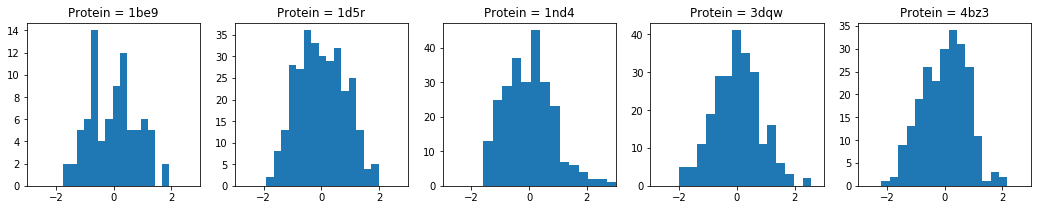

Measure = edges


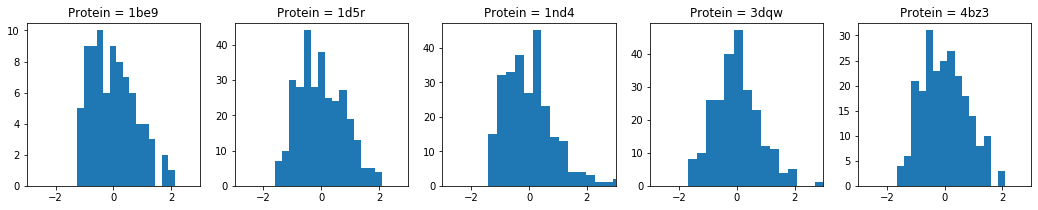

Measure = weight


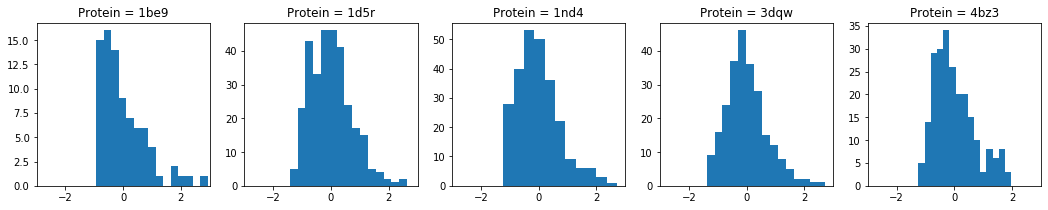

Measure = distance


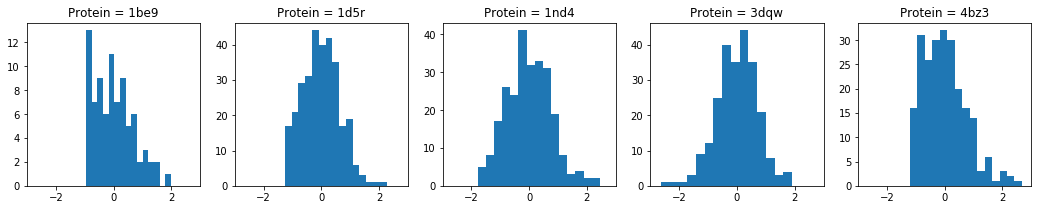

In [63]:
# Histograms showing average values for standardized perturbation network data by measure
for measure in measures:
    threshold = 3.8 if measure == 'distance' else 5.0
    print(f'Measure = {measure}')
    data = {protein:Standardize(protein, threshold, measure) for protein in proteins}
    GraphDistribution(data)

Aunque los datos de redes de perturbación están mejor distribuidos, llegan a pasar cosas extrañas, sobre todo con algunos datos negativos (al tomar los datos estandarizados, serían los que están abajo del promedio). Por ejemplo, en 1be9 tenemos muchos valores alrededor del -1, y nada abajo. Eso se ve reflejado en algunas predicciones, donde cambian los porcentajes de predicciones con las desviaciones estándar.

Functional Data


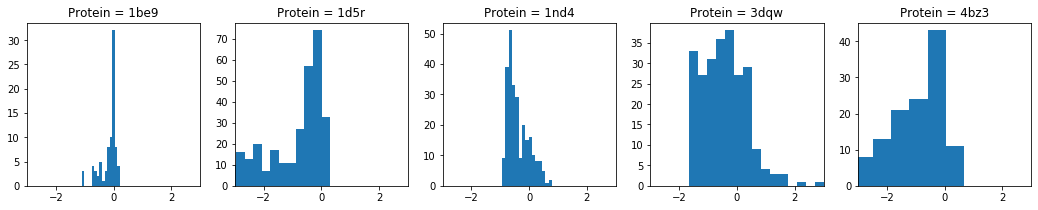

All Negatives


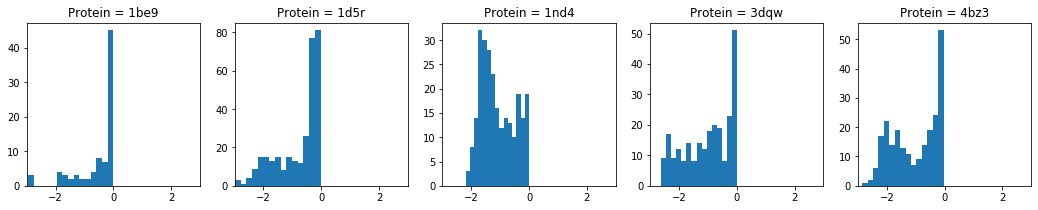

All Positives


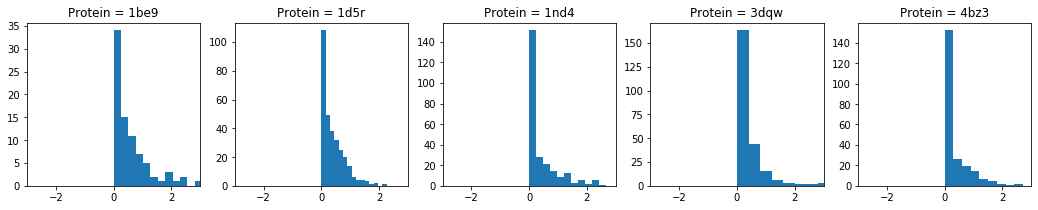

In [79]:
# Histograms showing average values for functional data, all_negatives, and all_positives
print('Functional Data')
GraphDistribution(functional_data)
print('All Negatives')
GraphDistribution(all_negatives)
print('All Positives')
GraphDistribution(all_positives)

Vemos cómo cambian los datos al considerar solo los negativos o solo los positivos y ajustarlos a tener desviación estándar 1. Aunque tienen distribuciones muy distintas, en general logramos una mejor distribución de los valores no promedio. Es más variable en los negativos, pero en todos los casos alcanzamos a ver valores hasta dos desviaciones estándar abajo del cero. Los positivos se comportan mejor, igual llegamos a dos distribuciones estándar arriba del promedio, pero cada vez menos, lo que surge de lo que ya habíamos considerado sobre cómo no pueden mejorar demasiado porque las proteínas ya son bastante buenas. 

El caso más extraño es 1nd4, que supongo viene del hecho de que la distribución original está muy inclinada hacia los negativos, mientras que las demás están más centradas al cero. Eso refleja bien las mediciones originales, que nos muestran más posiciones que en promedio son sensibles, y podría ser un argumento a favor de filtrar por desviaciones estándar. 

In [17]:
def GetPercentage(percentage, which, data):
    """Return set with top or bottom percentage of positions according to functional data. 
    Parameters:
        percentage (float): between 0 and 1, percentage of positions that we want.
        which (str): 'highest', 'lowest'
        data (dataframe): functional data to consider mean of
    
    Returns:
        Set of positions.
    """
    functional_mean = data.mean()
    positions = list(data.columns)
    pairs = [(functional_mean[pos], pos) for pos in positions] 
    pairs.sort(key = lambda x:x[0]) 
    if which == 'highest': 
        pairs.reverse() 
    n = int(len(positions)*percentage)
    return set([pair[1] for pair in pairs[:n]])

In [18]:
def GetSD(sd, data):
    """ Return set with positions with mean scores above (if sd > 0) or below (if sd < 0) sd according to 
    functional data."""
    functional_mean = data.mean()
    positions = list(data.columns)
    if sd > 0:
        return set([pos for pos in positions if functional_mean[pos] > sd])
    else: 
        return set([pos for pos in positions if functional_mean[pos] < sd])

In [19]:
def GetNetworkExtremes(protein, mincount, measure_cutoffs, thresh=5.0):
    """ Return set with positions that pass measure sd cutoffs for at least mincount measures. """
    network_extremes_list = []
    for i,measure in enumerate(measures): 
        threshold = 3.8 if measure == 'distance' else thresh
        network_df = Standardize(protein, threshold, measure)
        if measure_cutoffs[i] > 0:
            extremes = network_df.columns[(network_df > measure_cutoffs[i]).any()].tolist()
        else:
            extremes = network_df.columns[(network_df < measure_cutoffs[i]).any()].tolist()
        network_extremes_list.extend(extremes)

    counter = Counter(network_extremes_list)
    positions = list(set(network_extremes_list))
    return set([pos for pos in positions if counter[pos] >= mincount])

In [20]:
def ToPercentage(a,b):
    """Return percentage form of a/b, if b != 0. If given set or list, use len of. """
    x = a if type(a) == int or type(a) == float else len(a)
    y = b if type(b) == int or type(b) == float else len(b)
    
    if y == 0:
        return np.nan
    else:
        return f'{round(100*x/y, 1)}%'

```
True Positives: positions deemed sensitive by functional data and predicted sensitive by network data. 
False Positives: positions predicted sensitive that are not below functional data cutoff. 
Coverage (%): accurately predicted positions / functionally sensitive positions
Accuracy (%): accurately predicted positions / predicted positions
Functional percentage (%): percentage of positions considered sensitive by functional data
Prediction percentage (%): percentage of positions predicted as sensitive```

In [71]:
def ComparePredictionsLoss(functional_cutoff, network_mincount, measure_cutoffs=[1,1,1,1], 
                           funct_method='percentage', data=all_negatives, thresh=5.0):
    """Compare positions with mean functional values below cutoff with predicted positions above cutoff for 
    perturbation network data. Return True Positives, False Positives, Coverage, Accuracy, and percentages of 
    positions. 
    
    Parameters:
        functional_cutoff (float): If funct_method is 'sd', standard deviations below 0 that determine which 
                                   positions are selected. If funct_method is 'percentage', take that percentage of 
                                   positions with lowest mean scores. 
        network_mincount (int): Minimum number of measures for which a position needs to pass cutoff to be predicted 
                              functionally sensitive. Int between 1 and 4, inclusive. 
        measure_cutoffs (list, 4 ints): Standard deviations above average that determine predictions for each measure.
                                        In order, [nodes, edges, weight, distance].
        data (dict): Contains dataframes with functional data, default all_negatives.
        funct_method (str): 'percentage' or 'sd', determines method to select positions to compare predictions to. 
                            Default 'percentage'. 
    """
    predict = pd.DataFrame(index=proteins, columns=['True Positives', 'False Positives', 'Coverage', 'Accuracy',
                                                          'Prediction %', 'Functional %'])
    for protein in proteins:
        network_extremes = GetNetworkExtremes(protein, network_mincount, measure_cutoffs, thresh=thresh)
        funct_extremes = GetSD(functional_cutoff, data[protein]) if funct_method == 'sd' \
                                        else GetPercentage(functional_cutoff, 'lowest', data[protein])
        
        how_many = len(network_extremes.intersection(funct_extremes))
        positions = len(data[protein].columns)

        predict.at[protein, 'True Positives'] = how_many
        predict.at[protein, 'False Positives'] = len(network_extremes) - how_many 
        predict.at[protein,'Coverage']= ToPercentage(how_many, funct_extremes)
        predict.at[protein, 'Accuracy'] = ToPercentage(how_many, network_extremes)
        predict.at[protein,'Functional %'] = ToPercentage(funct_extremes, positions)
        predict.at[protein,'Prediction %'] = ToPercentage(network_extremes, positions)
        
    method = f'{functional_cutoff} SD' if funct_method == 'sd' else f'{functional_cutoff*100}%'
    print("Loss of function predictions:")
    print(f'mincount = {network_mincount}, functional cutoff = {method}, measure cutoffs = {measure_cutoffs}')
    display(predict)
    return 

No están tan bien distribuidos los datos de redes abajo del promedio, pero abajo de -1 da posiciones para casi todas las proteínas y medidas. 

In [72]:
def ComparePredictionsGain(functional_cutoff, network_mincount, measure_cutoffs=[-1,-1,-1,-1], 
                           funct_method='percentage', data=all_positives, thresh=5.0):
    """Compare positions with mean functional values above cutoff with predicted positions below cutoff for 
    perturbation network data. Return True Positives, False Positives, Coverage, Accuracy, and percentages of 
    positions. 
    
    Parameters:
        functional_cutoff (float): If funct_method is 'sd', standard deviations above 0 that determine which 
                                   positions are selected. If funct_method is 'percentage', take that percentage of 
                                   positions with highest mean scores. 
        network_mincount (int): Minimum number of measures for which a position needs to pass cutoff to be predicted 
                              functionally sensitive. Int between 1 and 4, inclusive. 
        measure_cutoffs (list, 4 ints): Standard deviations below average that determine predictions for each measure.
                                        In order, [nodes, edges, weight, distance].
        data (dict): Contains dataframes with functional data, default all_positives.
        funct_method (str): 'percentage' or 'sd', determines method to select positions to compare predictions to. 
                            Default 'percentage'. 
    """
    predict = pd.DataFrame(index=proteins, columns=['True Positives', 'False Positives', 'Coverage', 'Accuracy',
                                                          'Prediction %', 'Functional %'])
    for protein in proteins:
        network_extremes = GetNetworkExtremes(protein, network_mincount, measure_cutoffs, thresh=thresh)
        funct_extremes = GetSD(functional_cutoff, data[protein]) if funct_method == 'sd' \
                                        else GetPercentage(functional_cutoff, 'highest', data[protein])
            
        how_many = len(network_extremes.intersection(funct_extremes))
        positions = len(data[protein].columns)

        predict.at[protein, 'True Positives'] = how_many
        predict.at[protein, 'False Positives'] = len(network_extremes) - how_many 
        predict.at[protein,'Coverage']= ToPercentage(how_many, funct_extremes)
        predict.at[protein, 'Accuracy'] = ToPercentage(how_many, network_extremes)
        predict.at[protein,'Functional %'] = ToPercentage(funct_extremes, positions)
        predict.at[protein,'Prediction %'] = ToPercentage(network_extremes, positions)
        
    method = f'{functional_cutoff} SD' if funct_method == 'sd' else f'{functional_cutoff*100}%'
    print("Gain of function predictions:")
    print(f'mincount = {network_mincount}, functional cutoff = {method}, measure cutoffs = {measure_cutoffs}')
    display(predict)
    return 

In [83]:
ComparePredictionsLoss(-1, 4, funct_method = 'sd')

Loss of function predictions:
mincount = 4, functional cutoff = -1 SD, measure cutoffs = [1, 1, 1, 1]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,13,24,76.5%,35.1%,44.6%,20.5%
1d5r,76,39,77.6%,66.1%,37.5%,31.9%
1nd4,82,6,53.2%,93.2%,34.5%,60.4%
3dqw,66,44,61.1%,60.0%,45.5%,44.6%
4bz3,80,16,71.4%,83.3%,41.6%,48.5%


In [80]:
for i in range(1,5):
    ComparePredictionsLoss(0.4, i, measure_cutoffs=[1,1,1.5,1.5])

Loss of function predictions:
mincount = 1, functional cutoff = 40.0%, measure cutoffs = [1, 1, 1.5, 1.5]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,30,28,90.9%,51.7%,69.9%,39.8%
1d5r,113,97,92.6%,53.8%,68.4%,39.7%
1nd4,89,55,87.3%,61.8%,56.5%,40.0%
3dqw,73,74,76.0%,49.7%,60.7%,39.7%
4bz3,89,58,96.7%,60.5%,63.6%,39.8%


Loss of function predictions:
mincount = 2, functional cutoff = 40.0%, measure cutoffs = [1, 1, 1.5, 1.5]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,27,18,81.8%,60.0%,54.2%,39.8%
1d5r,105,51,86.1%,67.3%,50.8%,39.7%
1nd4,75,40,73.5%,65.2%,45.1%,40.0%
3dqw,65,64,67.7%,50.4%,53.3%,39.7%
4bz3,82,40,89.1%,67.2%,52.8%,39.8%


Loss of function predictions:
mincount = 3, functional cutoff = 40.0%, measure cutoffs = [1, 1, 1.5, 1.5]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,25,16,75.8%,61.0%,49.4%,39.8%
1d5r,101,34,82.8%,74.8%,44.0%,39.7%
1nd4,69,27,67.6%,71.9%,37.6%,40.0%
3dqw,58,52,60.4%,52.7%,45.5%,39.7%
4bz3,74,30,80.4%,71.2%,45.0%,39.8%


Loss of function predictions:
mincount = 4, functional cutoff = 40.0%, measure cutoffs = [1, 1, 1.5, 1.5]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,21,10,63.6%,67.7%,37.3%,39.8%
1d5r,78,24,63.9%,76.5%,33.2%,39.7%
1nd4,48,16,47.1%,75.0%,25.1%,40.0%
3dqw,39,28,40.6%,58.2%,27.7%,39.7%
4bz3,57,21,62.0%,73.1%,33.8%,39.8%


Si eligieramos al azar el mismo número de posiciones que predecimos, esperaríamos que Coverage fuera aproximadamente Prediction %, pues es el porcentaje que elegimos del total que queremos comparar, mientras que Accuracy sería aproximadamente Functional %, el porcentaje del total que tiene cambios funcionales. 

Notamos que siempre tenemos valores más altos tanto en Coverage como en Accuracy, aún cuando Accuracy no es tan buena, lo que es una señal de que aún considerando mincount = 1, ya estamos teniendo información de las redes de perturbación. Con mincount = 4, se reduce bastante el porcentaje de predicciones, y alcanzamos precisión y cobertura de cerca del doble de lo que esperaríamos seleccionando al azar. 

En cuanto a desviaciones vs porcentaje, creo que ambas son comparaciones válidas. Aunque por porcentaje da resultados más parecidos entre sí, hay casos como 1nd4, que tiene muchos valores más cerca del -1 que del 0 en sus datos funcionales normales, y el porcentaje de posiciones que captura casi todas las posiciones sensibles para las demás proteínas no captura todas para esa. En particular, con mincount = 4, accuracy sube de 75% a 93% cambiando de 40% a 1 SD, con cobertura de 47% a 53%. Por otro lado, al cambiar de porcentaje a desviaciones para 1be9, disminuye bastante la precisión. Al final, todo depende de la distribución de los valores negativos (no sé que tan bueno sea eso...) pero siempre tenemos algo de información. 

In [112]:
for i in range(1,5):
    ComparePredictionsLoss(0.4, i, measure_cutoffs=[1.5,1.5,2,2])

Loss of function predictions:
mincount = 1, functional cutoff = 40.0%, measure cutoffs = [1.5, 1.5, 2, 2]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,27,17,81.8%,61.4%,53.0%,39.8%
1d5r,99,50,81.1%,66.4%,48.5%,39.7%
1nd4,76,37,74.5%,67.3%,44.3%,40.0%
3dqw,57,54,59.4%,51.4%,45.9%,39.7%
4bz3,79,35,85.9%,69.3%,49.4%,39.8%


Loss of function predictions:
mincount = 2, functional cutoff = 40.0%, measure cutoffs = [1.5, 1.5, 2, 2]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,23,12,69.7%,65.7%,42.2%,39.8%
1d5r,89,25,73.0%,78.1%,37.1%,39.7%
1nd4,62,19,60.8%,76.5%,31.8%,40.0%
3dqw,50,39,52.1%,56.2%,36.8%,39.7%
4bz3,69,22,75.0%,75.8%,39.4%,39.8%


Loss of function predictions:
mincount = 3, functional cutoff = 40.0%, measure cutoffs = [1.5, 1.5, 2, 2]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,17,7,51.5%,70.8%,28.9%,39.8%
1d5r,75,18,61.5%,80.6%,30.3%,39.7%
1nd4,50,12,49.0%,80.6%,24.3%,40.0%
3dqw,42,30,43.8%,58.3%,29.8%,39.7%
4bz3,51,18,55.4%,73.9%,29.9%,39.8%


Loss of function predictions:
mincount = 4, functional cutoff = 40.0%, measure cutoffs = [1.5, 1.5, 2, 2]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,10,5,30.3%,66.7%,18.1%,39.8%
1d5r,29,4,23.8%,87.9%,10.7%,39.7%
1nd4,28,6,27.5%,82.4%,13.3%,40.0%
3dqw,20,9,20.8%,69.0%,12.0%,39.7%
4bz3,14,8,15.2%,63.6%,9.5%,39.8%


Creo que de lo que tenemos justo arriba, min count 2, functional 40%, measure cutoffs [1.5, 1.5, 2, 2] es un buen ejemplo, coverage y accuracy son ambos buenos en promedio, y muy parecidos entre sí. Además, el porcentaje de funcionales y predicciones se parece, que creo igual es importante considerar. Nos da más o menos la misma precisión que mincount = 4 para [1,1,1.5,1.5], con mejor cobertura. 

Parece que podemos mejorar nuestras predicciones al azar por un factor entre 1.5 y 2, que me parece bastante bueno. Además, parece ser bastante consistente a lo largo de todas las formas de comparar para el mismo porcentaje de datos funcionales. Es decir, Coverage/Prediction % es súper consistente para cada proteína con distintos mincounts y thresholds, Accuracy/Functional % también es bastante consistente, aunque hay ligeros cambios, aumentando conforme nos ponemos más estrictos. 

In [86]:
ComparePredictionsLoss(0.4, 4, measure_cutoffs=[1.5,1.5,1.5,1.5])
ComparePredictionsLoss(0.4, 4, measure_cutoffs=[1.5,1.5,1.5,1.5], thresh=9.0)
ComparePredictionsLoss(0.4, 4, measure_cutoffs=[1.5,1.5,1.5,1.5], thresh=10.0)

Loss of function predictions:
mincount = 4, functional cutoff = 40.0%, measure cutoffs = [1.5, 1.5, 1.5, 1.5]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,18,9,54.5%,66.7%,32.5%,39.8%
1d5r,72,16,59.0%,81.8%,28.7%,39.7%
1nd4,40,11,39.2%,78.4%,20.0%,40.0%
3dqw,34,20,35.4%,63.0%,22.3%,39.7%
4bz3,48,15,52.2%,76.2%,27.3%,39.8%


Loss of function predictions:
mincount = 4, functional cutoff = 40.0%, measure cutoffs = [1.5, 1.5, 1.5, 1.5]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,14,7,42.4%,66.7%,25.3%,39.8%
1d5r,68,13,55.7%,84.0%,26.4%,39.7%
1nd4,37,5,36.3%,88.1%,16.5%,40.0%
3dqw,37,14,38.5%,72.5%,21.1%,39.7%
4bz3,49,5,53.3%,90.7%,23.4%,39.8%


Loss of function predictions:
mincount = 4, functional cutoff = 40.0%, measure cutoffs = [1.5, 1.5, 1.5, 1.5]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,13,6,39.4%,68.4%,22.9%,39.8%
1d5r,65,8,53.3%,89.0%,23.8%,39.7%
1nd4,40,5,39.2%,88.9%,17.6%,40.0%
3dqw,34,14,35.4%,70.8%,19.8%,39.7%
4bz3,38,5,41.3%,88.4%,18.6%,39.8%


Usar 5 a usar 9 como threshold sí parece hacer algo de diferencia en accuracy. Estoy muy confundida al respecto. 1nd4 es la que tiene exactamente la misma correlación de spearman para thresholds > 4, pero la diferencia con los dos thresholds es casi 10% de precisión. 3dqw sí crece bastante su correlación de spearman conforme crece el threshold. Creo que sería interesante ver cómo se comparan las predicciones para un threshold y para otro. 

In [87]:
for i in range(1,5):
    ComparePredictionsGain(1, i, funct_method = 'sd', measure_cutoffs = [-1, -1, -1, -1])

Gain of function predictions:
mincount = 1, functional cutoff = 1 SD, measure cutoffs = [-1, -1, -1, -1]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,9,23,52.9%,28.1%,38.6%,20.5%
1d5r,20,215,76.9%,8.5%,76.5%,8.5%
1nd4,35,150,87.5%,18.9%,72.5%,15.7%
3dqw,21,166,84.0%,11.2%,77.3%,10.3%
4bz3,24,154,82.8%,13.5%,77.1%,12.6%


Gain of function predictions:
mincount = 2, functional cutoff = 1 SD, measure cutoffs = [-1, -1, -1, -1]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,9,20,52.9%,31.0%,34.9%,20.5%
1d5r,15,164,57.7%,8.4%,58.3%,8.5%
1nd4,32,90,80.0%,26.2%,47.8%,15.7%
3dqw,16,142,64.0%,10.1%,65.3%,10.3%
4bz3,22,113,75.9%,16.3%,58.4%,12.6%


Gain of function predictions:
mincount = 3, functional cutoff = 1 SD, measure cutoffs = [-1, -1, -1, -1]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,7,12,41.2%,36.8%,22.9%,20.5%
1d5r,15,132,57.7%,10.2%,47.9%,8.5%
1nd4,30,68,75.0%,30.6%,38.4%,15.7%
3dqw,16,116,64.0%,12.1%,54.5%,10.3%
4bz3,20,90,69.0%,18.2%,47.6%,12.6%


Gain of function predictions:
mincount = 4, functional cutoff = 1 SD, measure cutoffs = [-1, -1, -1, -1]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,0,0,0.0%,NaN,0.0%,20.5%
1d5r,12,110,46.2%,9.8%,39.7%,8.5%
1nd4,27,58,67.5%,31.8%,33.3%,15.7%
3dqw,10,98,40.0%,9.3%,44.6%,10.3%
4bz3,11,70,37.9%,13.6%,35.1%,12.6%


In [88]:
for i in range(1,5):
    ComparePredictionsGain(0.4, i, measure_cutoffs = [-1, -1, -1, -1])

Gain of function predictions:
mincount = 1, functional cutoff = 40.0%, measure cutoffs = [-1, -1, -1, -1]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,18,14,54.5%,56.2%,38.6%,39.8%
1d5r,106,129,86.9%,45.1%,76.5%,39.7%
1nd4,92,93,90.2%,49.7%,72.5%,40.0%
3dqw,81,106,84.4%,43.3%,77.3%,39.7%
4bz3,78,100,84.8%,43.8%,77.1%,39.8%


Gain of function predictions:
mincount = 2, functional cutoff = 40.0%, measure cutoffs = [-1, -1, -1, -1]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,18,11,54.5%,62.1%,34.9%,39.8%
1d5r,92,87,75.4%,51.4%,58.3%,39.7%
1nd4,74,48,72.5%,60.7%,47.8%,40.0%
3dqw,72,86,75.0%,45.6%,65.3%,39.7%
4bz3,71,64,77.2%,52.6%,58.4%,39.8%


Gain of function predictions:
mincount = 3, functional cutoff = 40.0%, measure cutoffs = [-1, -1, -1, -1]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,14,5,42.4%,73.7%,22.9%,39.8%
1d5r,80,67,65.6%,54.4%,47.9%,39.7%
1nd4,66,32,64.7%,67.3%,38.4%,40.0%
3dqw,64,68,66.7%,48.5%,54.5%,39.7%
4bz3,65,45,70.7%,59.1%,47.6%,39.8%


Gain of function predictions:
mincount = 4, functional cutoff = 40.0%, measure cutoffs = [-1, -1, -1, -1]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,0,0,0.0%,NaN,0.0%,39.8%
1d5r,66,56,54.1%,54.1%,39.7%,39.7%
1nd4,57,28,55.9%,67.1%,33.3%,40.0%
3dqw,50,58,52.1%,46.3%,44.6%,39.7%
4bz3,45,36,48.9%,55.6%,35.1%,39.8%


Las predicciones se vuelven complicadas porque no están tan bien distribuidos los datos de redes hacia abajo. Parece que son casi al azar, fuera de 1nd4 y 1be9, no parece que tengamos mucha información, los porcentajes de accuracy se parecen mucho al porcentaje de funcionales sensibles. Creo que decir que tiene al menos una mutación estable no es tan buena métrica para ganancia de función, podemos considerar el promedio. 

In [91]:
def ComparePredictionsGain2(functional_cutoff, network_mincount, measure_cutoffs=[-1,-1,-1,-1], 
                           funct_method='percentage', data=all_positives):
    """ComparePredictionsGain with network mean for prediction selection."""
    predict = pd.DataFrame(index=proteins, columns=['True Positives', 'False Positives', 'Coverage', 'Accuracy',
                                                          'Prediction %', 'Functional %'])
    for protein in proteins:
        network_extremes_list = []
        for i,measure in enumerate(measures): 
            threshold = 3.8 if measure == 'distance' else 5.0
            network_df = Standardize(protein, threshold, measure)
            network_mean = network_df.mean()
            extremes = set([pos for pos in network_df.columns if network_mean[pos] < measure_cutoffs[i]])
            network_extremes_list.extend(extremes)

        counter = Counter(network_extremes_list)
        positions = list(set(network_extremes_list))
        network_extremes = set([pos for pos in positions if counter[pos] >= network_mincount])
        funct_extremes = GetSD(functional_cutoff, data[protein]) if funct_method == 'sd' \
                                        else GetPercentage(functional_cutoff, 'highest', data[protein])
        
        how_many = len(network_extremes.intersection(funct_extremes))
        positions = len(data[protein].columns)

        predict.at[protein, 'True Positives'] = how_many
        predict.at[protein, 'False Positives'] = len(network_extremes) - how_many 
        predict.at[protein,'Coverage']= ToPercentage(how_many, funct_extremes)
        predict.at[protein, 'Accuracy'] = ToPercentage(how_many, network_extremes)
        predict.at[protein,'Functional %'] = ToPercentage(funct_extremes, positions)
        predict.at[protein,'Prediction %'] = ToPercentage(network_extremes, positions)
        
    method = f'{functional_cutoff} SD' if funct_method == 'sd' else f'{functional_cutoff*100}%'
    print("Gain of function predictions:")
    print(f'mincount = {network_mincount}, functional cutoff = {method}, measure cutoffs = {measure_cutoffs}')
    display(predict)
    return 

In [92]:
for i in range(1,5):
    ComparePredictionsGain2(1, i, funct_method = 'sd', measure_cutoffs = [-1, -1, -1, -1])

Gain of function predictions:
mincount = 1, functional cutoff = 1 SD, measure cutoffs = [-1, -1, -1, -1]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,3,6,17.6%,33.3%,10.8%,20.5%
1d5r,2,36,7.7%,5.3%,12.4%,8.5%
1nd4,13,26,32.5%,33.3%,15.3%,15.7%
3dqw,2,25,8.0%,7.4%,11.2%,10.3%
4bz3,7,25,24.1%,21.9%,13.9%,12.6%


Gain of function predictions:
mincount = 2, functional cutoff = 1 SD, measure cutoffs = [-1, -1, -1, -1]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,2,5,11.8%,28.6%,8.4%,20.5%
1d5r,1,30,3.8%,3.2%,10.1%,8.5%
1nd4,9,22,22.5%,29.0%,12.2%,15.7%
3dqw,2,19,8.0%,9.5%,8.7%,10.3%
4bz3,6,10,20.7%,37.5%,6.9%,12.6%


Gain of function predictions:
mincount = 3, functional cutoff = 1 SD, measure cutoffs = [-1, -1, -1, -1]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,0,0,0.0%,NaN,0.0%,20.5%
1d5r,1,19,3.8%,5.0%,6.5%,8.5%
1nd4,8,14,20.0%,36.4%,8.6%,15.7%
3dqw,2,16,8.0%,11.1%,7.4%,10.3%
4bz3,4,6,13.8%,40.0%,4.3%,12.6%


Gain of function predictions:
mincount = 4, functional cutoff = 1 SD, measure cutoffs = [-1, -1, -1, -1]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,0,0,0.0%,NaN,0.0%,20.5%
1d5r,1,10,3.8%,9.1%,3.6%,8.5%
1nd4,4,7,10.0%,36.4%,4.3%,15.7%
3dqw,1,13,4.0%,7.1%,5.8%,10.3%
4bz3,2,3,6.9%,40.0%,2.2%,12.6%


Es peor que la anterior, y es interesante que para tres de las proteínas podemos predecir más o menos, y para dos parece que nos va peor que elegir al azar. 

Volviendo a comparar los thresholds, vamos a checar cómo se comparan las predicciones de posiciones para 5.0 y para 9.0. 

In [31]:
for measure in ['nodes', 'edges', 'weight']:
    df = pd.DataFrame(index=proteins, columns=['in 5.0/total 9.0', 'in 9.0/total 5.0'])
    for protein in proteins:
        network_df_5 = Standardize(protein, 5.0, measure)
        network_extremes_5 = set(network_df_5.columns[(network_df_5 > 1.5).any()].tolist())
        
        network_df_9 = Standardize(protein, 9.0, measure)
        network_extremes_9 = set(network_df_9.columns[(network_df_9 > 1.5).any()].tolist())
        #if network_extremes_5 == network_extremes_9:
            #print(protein, measure)
        both = network_extremes_5.intersection(network_extremes_9)
        df.at[protein, 'in 5.0/total 9.0'] = round(len(both)/len(network_extremes_9), 2)
        df.at[protein, 'in 9.0/total 5.0'] = round(len(both)/len(network_extremes_5), 2)
    print(measure)
    display(df)

nodes


,in 5.0/total 9.0,in 9.0/total 5.0
1be9,0.93,0.75
1d5r,0.91,0.84
1nd4,0.88,0.75
3dqw,0.77,0.72
4bz3,0.87,0.75


edges


,in 5.0/total 9.0,in 9.0/total 5.0
1be9,0.93,0.85
1d5r,0.95,0.92
1nd4,0.93,0.82
3dqw,0.86,0.87
4bz3,0.91,0.96


weight


,in 5.0/total 9.0,in 9.0/total 5.0
1be9,0.86,0.91
1d5r,0.79,0.84
1nd4,0.74,0.93
3dqw,0.71,0.94
4bz3,0.83,0.88


No está completamente contenido uno en el otro, y parece que la contención es algo distinta según la medida... Vamos a comparar las de pérdida de función con la intersección entre los de 5.0 y los de 9.0. La hipótesis es que debería tener mayor accuracy. 

In [93]:
def ComparePredictionsLoss2(functional_cutoff, network_mincount, measure_cutoffs=[1,1,1,1], 
                           funct_method='percentage', data=all_negatives):
    """ComparePredictionsLoss using intersection for thresholds 5.0 and 9.0 for predictions. """
    predict = pd.DataFrame(index=proteins, columns=['True Positives', 'False Positives', 'Coverage', 'Accuracy',
                                                          'Prediction %', 'Functional %'])
    for protein in proteins:
        network_extremes_list = []
        for i,measure in enumerate(measures): 
            if measure == 'distance':
                threshold = 3.8
                network_df = Standardize(protein, threshold, measure)
                extremes = network_df.columns[(network_df > measure_cutoffs[i]).any()].tolist()
                network_extremes_list.extend(extremes)
            else:
                network_df_5 = Standardize(protein, 5.0, measure)
                network_extremes_5 = set(network_df_5.columns[(network_df_5 > 1.5).any()].tolist())
                network_df_9 = Standardize(protein, 9.0, measure)
                network_extremes_9 = set(network_df_9.columns[(network_df_9 > 1.5).any()].tolist())
                extremes = network_extremes_5.intersection(network_extremes_9)
                network_extremes_list.extend(extremes)

        counter = Counter(network_extremes_list)
        positions = list(set(network_extremes_list))
        network_extremes = set([pos for pos in positions if counter[pos] >= network_mincount])
        funct_extremes = GetSD(functional_cutoff, data[protein]) if funct_method == 'sd' \
                                        else GetPercentage(functional_cutoff, 'lowest', data[protein])
                 
        how_many = len(network_extremes.intersection(funct_extremes))
        positions = len(data[protein].columns)

        predict.at[protein, 'True Positives'] = how_many
        predict.at[protein, 'False Positives'] = len(network_extremes) - how_many 
        predict.at[protein,'Coverage']= ToPercentage(how_many, funct_extremes)
        predict.at[protein, 'Accuracy'] = ToPercentage(how_many, network_extremes)
        predict.at[protein,'Functional %'] = ToPercentage(funct_extremes, positions)
        predict.at[protein,'Prediction %'] = ToPercentage(network_extremes, positions)
        
    method = f'{functional_cutoff} SD' if funct_method == 'sd' else f'{functional_cutoff*100}%'
    print("Loss of function predictions:")
    print(f'mincount = {network_mincount}, functional cutoff = {method}, measure cutoffs = {measure_cutoffs}')
    display(predict)
    return 

In [94]:
ComparePredictionsLoss(0.4, 4, measure_cutoffs=[1.5,1.5,1.5,1.5])
ComparePredictionsLoss(0.4, 4, measure_cutoffs=[1.5,1.5,1.5,1.5], thresh=9.0)
ComparePredictionsLoss2(0.4, 4, measure_cutoffs=[1.5,1.5,1.5,1.5])

Loss of function predictions:
mincount = 4, functional cutoff = 40.0%, measure cutoffs = [1.5, 1.5, 1.5, 1.5]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,18,9,54.5%,66.7%,32.5%,39.8%
1d5r,72,16,59.0%,81.8%,28.7%,39.7%
1nd4,40,11,39.2%,78.4%,20.0%,40.0%
3dqw,34,20,35.4%,63.0%,22.3%,39.7%
4bz3,48,15,52.2%,76.2%,27.3%,39.8%


Loss of function predictions:
mincount = 4, functional cutoff = 40.0%, measure cutoffs = [1.5, 1.5, 1.5, 1.5]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,14,7,42.4%,66.7%,25.3%,39.8%
1d5r,68,13,55.7%,84.0%,26.4%,39.7%
1nd4,37,5,36.3%,88.1%,16.5%,40.0%
3dqw,37,14,38.5%,72.5%,21.1%,39.7%
4bz3,49,5,53.3%,90.7%,23.4%,39.8%


Loss of function predictions:
mincount = 4, functional cutoff = 40.0%, measure cutoffs = [1.5, 1.5, 1.5, 1.5]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,13,7,39.4%,65.0%,24.1%,39.8%
1d5r,62,11,50.8%,84.9%,23.8%,39.7%
1nd4,33,5,32.4%,86.8%,14.9%,40.0%
3dqw,30,11,31.2%,73.2%,16.9%,39.7%
4bz3,43,5,46.7%,89.6%,20.8%,39.8%


Casi no hay cambio, lo cual coincide con que 9.0 da más información que 5.0, pero no estoy segura de por qué. Tal vez estamos logrando capturar más interacciones con los aminoácidos vecinos, o tal vez captura más efectos en cadena de cambios estructurales. 

Volviendo a la parte de ganancia de función, si las posiciones estructuralmente sensibles son las de pérdida de función, y las estables son las de ganancia, podríamos considerar las predicciónes de ganancia como el complemento de las predicciones de pérdida. Es decir, las que predecimos de pérdida son sensibles, y el resto son estables, dependiendo de cada una de las distintas métricas. Nos convendría al no usar los datos de gráficas abajo del promedio, que vimos que no están tan bien distribuidos. 

In [95]:
def ComparePredictionsGain3(functional_cutoff, network_mincount, measure_cutoffs=[1,1,1,1], 
                           funct_method='percentage', data=all_positives, thresh=5.0):
    """ComparePredictionsGain using complement of loss predictions. """
    predict = pd.DataFrame(index=proteins, columns=['True Positives', 'False Positives', 'Coverage', 'Accuracy',
                                                          'Prediction %', 'Functional %'])
    for protein in proteins:
        network_extremes_loss = GetNetworkExtremes(protein, network_mincount, measure_cutoffs, thresh=thresh)
        total_positions = data[protein].columns
        network_extremes = set([pos for pos in total_positions if pos not in network_extremes_loss])
        funct_extremes = GetSD(functional_cutoff, data[protein]) if funct_method == 'sd' \
                                        else GetPercentage(functional_cutoff, 'highest', data[protein])
        
        how_many = len(network_extremes.intersection(funct_extremes))
        positions = len(data[protein].columns)

        predict.at[protein, 'True Positives'] = how_many
        predict.at[protein, 'False Positives'] = len(network_extremes) - how_many 
        predict.at[protein,'Coverage']= ToPercentage(how_many, funct_extremes)
        predict.at[protein, 'Accuracy'] = ToPercentage(how_many, network_extremes)
        predict.at[protein,'Functional %'] = ToPercentage(funct_extremes, positions)
        predict.at[protein,'Prediction %'] = ToPercentage(network_extremes, positions)
        
    method = f'{functional_cutoff} SD' if funct_method == 'sd' else f'{functional_cutoff*100}%'
    print("Gain of function predictions:")
    print(f'mincount = {network_mincount}, functional cutoff = {method}, measure cutoffs = {measure_cutoffs}')
    display(predict)
    return 

In [98]:
for i in range(1,5):
    ComparePredictionsGain3(0.4, i, measure_cutoffs=[1,1,1,1])

Gain of function predictions:
mincount = 1, functional cutoff = 40.0%, measure cutoffs = [1, 1, 1, 1]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,16,9,48.5%,64.0%,30.1%,39.8%
1d5r,50,36,41.0%,58.1%,28.0%,39.7%
1nd4,63,22,61.8%,74.1%,33.3%,40.0%
3dqw,40,35,41.7%,53.3%,31.0%,39.7%
4bz3,46,23,50.0%,66.7%,29.9%,39.8%


Gain of function predictions:
mincount = 2, functional cutoff = 40.0%, measure cutoffs = [1, 1, 1, 1]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,19,17,57.6%,52.8%,43.4%,39.8%
1d5r,86,58,70.5%,59.7%,46.9%,39.7%
1nd4,80,43,78.4%,65.0%,48.2%,40.0%
3dqw,51,51,53.1%,50.0%,42.1%,39.7%
4bz3,62,37,67.4%,62.6%,42.9%,39.8%


Gain of function predictions:
mincount = 3, functional cutoff = 40.0%, measure cutoffs = [1, 1, 1, 1]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,20,21,60.6%,48.8%,49.4%,39.8%
1d5r,95,69,77.9%,57.9%,53.4%,39.7%
1nd4,86,56,84.3%,60.6%,55.7%,40.0%
3dqw,55,59,57.3%,48.2%,47.1%,39.7%
4bz3,67,44,72.8%,60.4%,48.1%,39.8%


Gain of function predictions:
mincount = 4, functional cutoff = 40.0%, measure cutoffs = [1, 1, 1, 1]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,21,25,63.6%,45.7%,55.4%,39.8%
1d5r,102,90,83.6%,53.1%,62.5%,39.7%
1nd4,91,76,89.2%,54.5%,65.5%,40.0%
3dqw,65,67,67.7%,49.2%,54.5%,39.7%
4bz3,76,59,82.6%,56.3%,58.4%,39.8%


In [121]:
ComparePredictionsGain3(0.4, 1,measure_cutoffs=[1,1,1,1])
ComparePredictionsGain3(0.4, 1,measure_cutoffs=[1,1,1,1], thresh=9.0)

Gain of function predictions:
mincount = 1, functional cutoff = 40.0%, measure cutoffs = [1, 1, 1, 1]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,16,9,48.5%,64.0%,30.1%,39.8%
1d5r,50,36,41.0%,58.1%,28.0%,39.7%
1nd4,63,22,61.8%,74.1%,33.3%,40.0%
3dqw,40,35,41.7%,53.3%,31.0%,39.7%
4bz3,46,23,50.0%,66.7%,29.9%,39.8%


Gain of function predictions:
mincount = 1, functional cutoff = 40.0%, measure cutoffs = [1, 1, 1, 1]


,True Positives,False Positives,Coverage,Accuracy,Prediction %,Functional %
1be9,17,8,51.5%,68.0%,30.1%,39.8%
1d5r,54,36,44.3%,60.0%,29.3%,39.7%
1nd4,57,21,55.9%,73.1%,30.6%,40.0%
3dqw,34,25,35.4%,57.6%,24.4%,39.7%
4bz3,43,19,46.7%,69.4%,26.8%,39.8%


Tenemos mejor información que con las otras formas de predecir, tiene mucho sentido, y nos ayuda a entender más cómo predecimos posiciones estructuralmente sensibles, pues mientras menos estrictos seamos con qué consideramos sensible, tenemos mejores predicciones de qué consideramos estable, y vice versa. Aunque no alcanzamos predicciones tan buenas cómo con pérdida, tenemos algo de información. Sin embargo, creo que es importante resaltar que más que ganancia de función, podemos predecir ganancia+sin cambios, porque nuestro accuracy baja mucho si nos ponemos más estrictos con el porcentaje de posiciones que consideramos de ganancia. 

Parece que el mejor porcentaje que podemos considerar es 40%, con 30% baja la precisión, y aunque crece un poco con más de 40% siento que ya sería muy extenso. 

In [123]:
# Best predictions for gain of function 
predictions_gain = dict()
for protein in proteins:
    network_extremes = GetNetworkExtremes(protein, 1, [1,1,1,1], thresh=9.0)
    positions = list(all_negatives[protein].columns)
    network_extremes_gain = [pos for pos in positions if pos not in network_extremes]
    network_extremes_gain.sort(key= lambda x:int(x[1:]))
    predictions_gain[protein] = network_extremes_gain

In [131]:
# Check percentage of predicted gain of function proteins with average values above 1, as well as percentage of
# predicted positions above one over all positions above 1
df = pd.DataFrame(index=proteins, columns=['% > 1 predictions', '% > 1 total', '% predicted > 1 / total > 1'])
for protein in proteins:
    mean = all_positives[protein].mean()
    mean_predictions = [round(mean[pos],2) for pos in predictions_gain[protein]]
    above_one = [i for i in mean_predictions if i >= 1]
    above_one_total = [i for i in mean if i > 1]
    df.at[protein, '% > 1 predictions'] = ToPercentage(above_one, mean_predictions)
    df.at[protein, '% > 1 total'] = ToPercentage(above_one_total, mean_predictions)
    df.at[protein, '% predicted > 1 / total > 1'] = ToPercentage(above_one,above_one_total)
display(df)

,% > 1 predictions,% > 1 total,% predicted > 1 / total > 1
1be9,40.0%,68.0%,58.8%
1d5r,12.2%,28.9%,42.3%
1nd4,32.1%,51.3%,62.5%
3dqw,18.6%,42.4%,44.0%
4bz3,19.4%,46.8%,41.4%


No predecimos todas las posiciones con valores funcionales promedio arriba de 1, y hay casos donde perdemos muchas, parece que podemos predecir ganancia o sin cambios. 

No sé si habría que volver a los datos funcionales normales para checar estas predicciones, porque puede que tengamos muchos valores cerca de cero que si tomamos el promedio normal (sin quitar los negativos) acaban siendo negativos. Aún en ese caso, suponemos que es un cambio funcional casi promedio. Creo que igual vale la pena validar nuestros cambios funcionales según all_positives y all_negatives con functional_data, y compararlos también con las posiciones sensibles de los artículos (que en general usan el promedio de functional_data). 